# Cross Selling
Cross selling in marketing: cross-selling models aim to suggest additional products to customers based on their current interests or purchases. \
Data typically includes socio-demographic, contact- and contract data.

### Use case of this notebook
see: https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data

Term deposits are a major source of income for a bank. A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term. The bank has various outreach plans to sell term deposits to their customers such as email marketing, advertisements, telephonic marketing, and digital marketing.

Telephonic marketing campaigns still remain one of the most effective way to reach out to people. However, they require huge investment as large call centers are hired to actually execute these campaigns. Hence, it is crucial to identify the customers most likely to convert beforehand so that they can be specifically targeted via call.

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).

### Real world problems:
- Administrative effort
- Speak the same language as the business
- Data quality and missing data
- Not enough features to build a good model
- Severely imbalanced data
- Positive unlabeled data
- How to measure success

https://github.com/timo-stoettner-axa/cas-ml-finance-axa-2024

### Import data

In [1]:
# Import libraries

import warnings
import pandas               as pd
import matplotlib.pyplot    as plt
import seaborn              as sns

from sklearn.model_selection        import cross_val_score
from sklearn.feature_selection      import SelectFromModel
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import RocCurveDisplay, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.ensemble               import RandomForestClassifier
from sklearn.linear_model           import LogisticRegression
from sklearn.preprocessing          import StandardScaler, OneHotEncoder
from sklearn.compose                import ColumnTransformer
from sklearn.pipeline               import Pipeline
from imblearn.under_sampling        import RandomUnderSampler

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import data
df_train_orig   = pd.read_csv('train.csv', sep=';')
df_test_orig    = pd.read_csv('test.csv', sep=';')
df_train_orig.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [3]:
# Subselection of expected relevant features -> start with few features, add more if necessary (forward selection)
rename_dict = {
    'age':          'age',
    'marital':      'marital',
    'job':          'job_category',
    'education':    'education_category',
    'housing':      'has_housing_loan',
    'month':        'last_contact_month_of_year',
    'duration':     'last_contact_duration',
    'y':            'y',
}

df_train    = df_train_orig[rename_dict.keys()].rename(columns=rename_dict)
df_test     = df_test_orig[rename_dict.keys()].rename(columns=rename_dict)

df_train.head(2)

,age,marital,job_category,education_category,has_housing_loan,last_contact_month_of_year,last_contact_duration,y
0,58,married,management,tertiary,yes,may,261,no
1,44,single,technician,secondary,yes,may,151,no


# Check data quality
- Is the data balanced
- Are data types correct
- Are there missing values
- How is the data distributed? Outliers?
- Are some features correlated with each other? -> Multicollinearity

##### Balance of dataset

In [4]:
df_train.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

##### Data types and missing values

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         45211 non-null  int64 
 1   marital                     45211 non-null  object
 2   job_category                45211 non-null  object
 3   education_category          45211 non-null  object
 4   has_housing_loan            45211 non-null  object
 5   last_contact_month_of_year  45211 non-null  object
 6   last_contact_duration       45211 non-null  int64 
 7   y                           45211 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.8+ MB


##### Distribution, outliers, number of unique values

In [6]:
df_train.describe(include=['number'], percentiles=[.5])

,age,last_contact_duration
count,45211.000000,45211.000000
mean,40.936210,258.163080
std,10.618762,257.527812
min,18.000000,0.000000
50%,39.000000,180.000000
max,95.000000,4918.000000


In [7]:
df_train.describe(include=['object'])

,marital,job_category,education_category,has_housing_loan,last_contact_month_of_year,y
count,45211,45211,45211,45211,45211,45211
unique,3,12,4,2,12,2
top,married,blue-collar,secondary,yes,may,no
freq,27214,9732,23202,25130,13766,39922


##### Distribution and multicollinearity

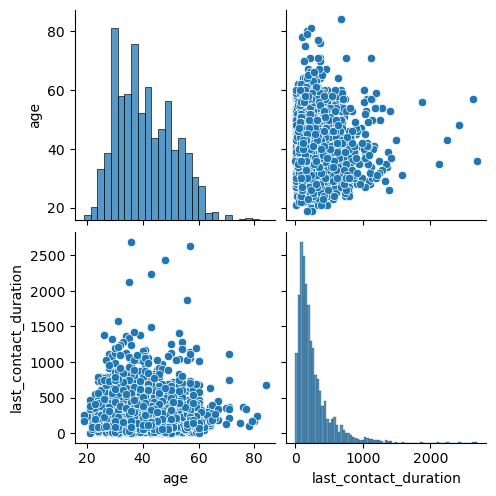

In [8]:
sns.pairplot(df_train.sample(frac=0.05))

### Plot all features

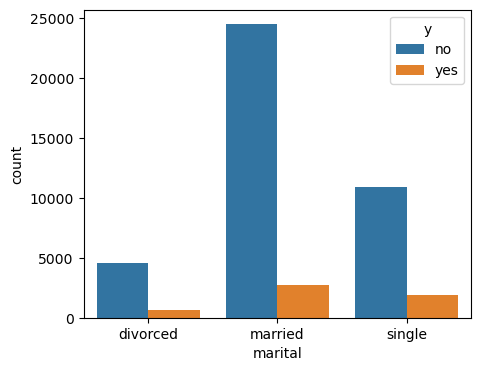

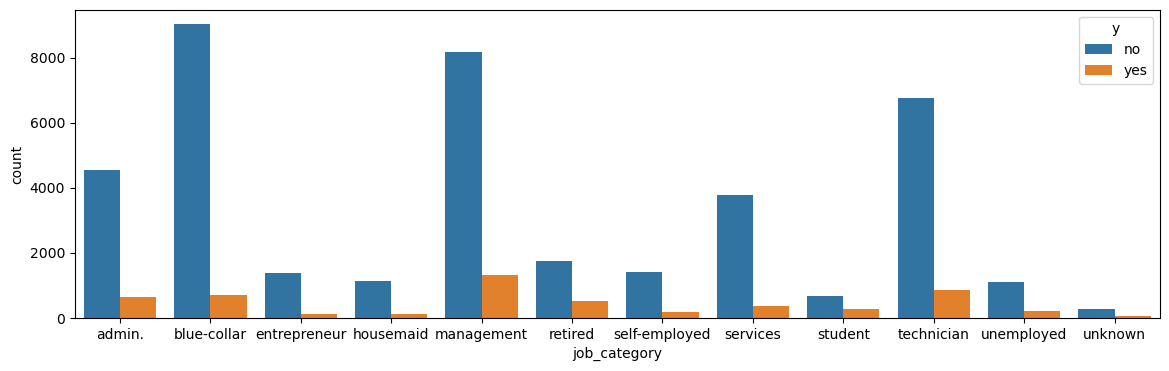

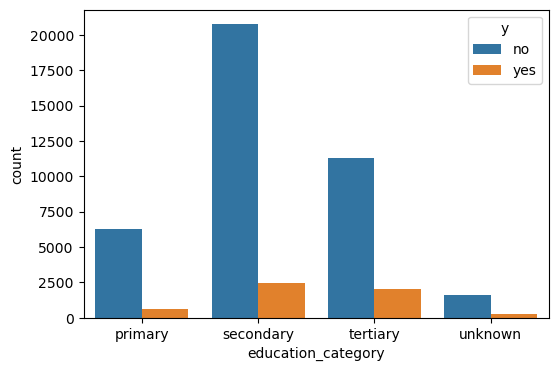

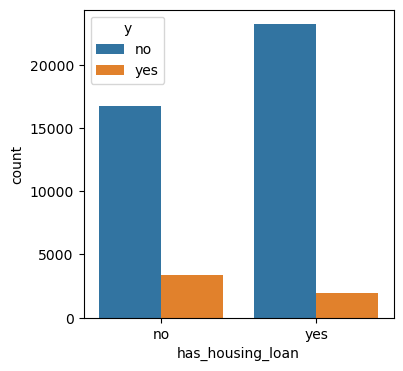

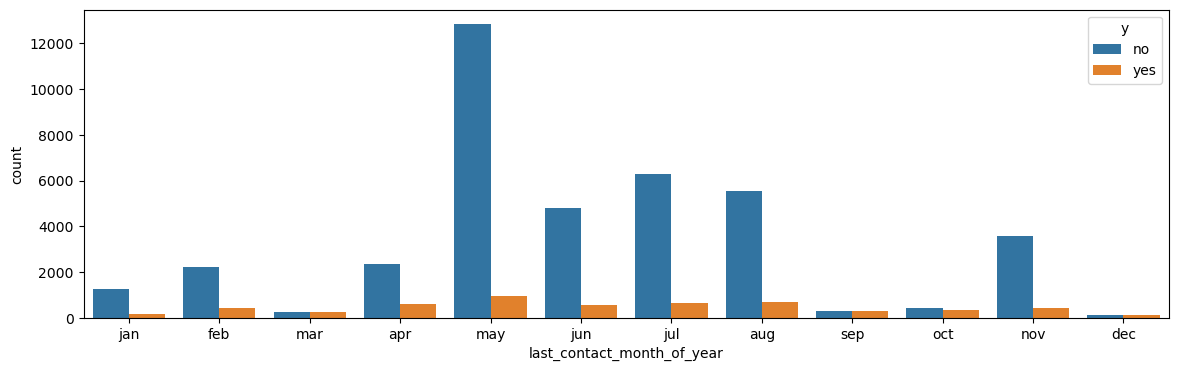

In [9]:
object_cols = df_train.select_dtypes(include=['object']).drop('y', axis=1).columns
month_sorting = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
for col in object_cols:
    n_levels = len(df_train[col].unique())
    plt.figure(figsize=(n_levels+2,4))
    if col != rename_dict['month']:
        sns.countplot(df_train.sort_values(col),x=col,hue='y')
    else:
        sns.countplot(df_train.sort_values(col, key=lambda column: column.map(lambda e: month_sorting.index(e))),x=col,hue='y')
    plt.show()

# Model training and evaluation

In [10]:
# Create X_train for training and X_val for validation of the different classifiers (use test data only at the end)

# Create X_train_b (b=balanced) and X_val
df_train['y'] = df_train_orig['y'].replace({'no':0, 'yes':1})
# Split data into training and validation sets
X_all=df_train.drop('y',axis=1)
y_all=df_train['y']
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Imbalanced dataset
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_b, y_train_b = rus.fit_resample(X_train, y_train)

# Test set
df_test['y'] = df_test_orig['y'].replace({'no':0, 'yes':1})
X_test=df_test.drop('y',axis=1)
y_test=df_test['y']

In [11]:
# Try some classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=5),
    'Logistic Regression': LogisticRegression(solver='liblinear', fit_intercept=True)
}

In [12]:
# Preprocessing -> numeric features = standard scaler (especially for logistic regression), categorical features = one hot encoding
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Classifier:  Random Forest
Precision:  0.3058135534915721
Recall:  0.8148487626031164
Accuracy:  0.7545062479265731
F1 Score:  0.44472236118059033


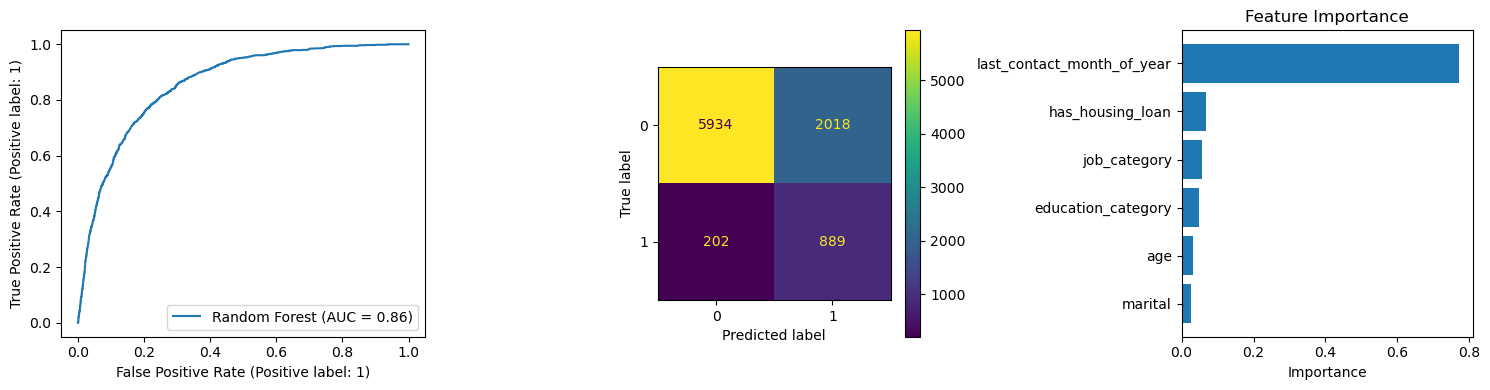

Classifier:  Logistic Regression
Precision:  0.37023914968999116
Recall:  0.766269477543538
Accuracy:  0.8145526926904788
F1 Score:  0.499253508510003


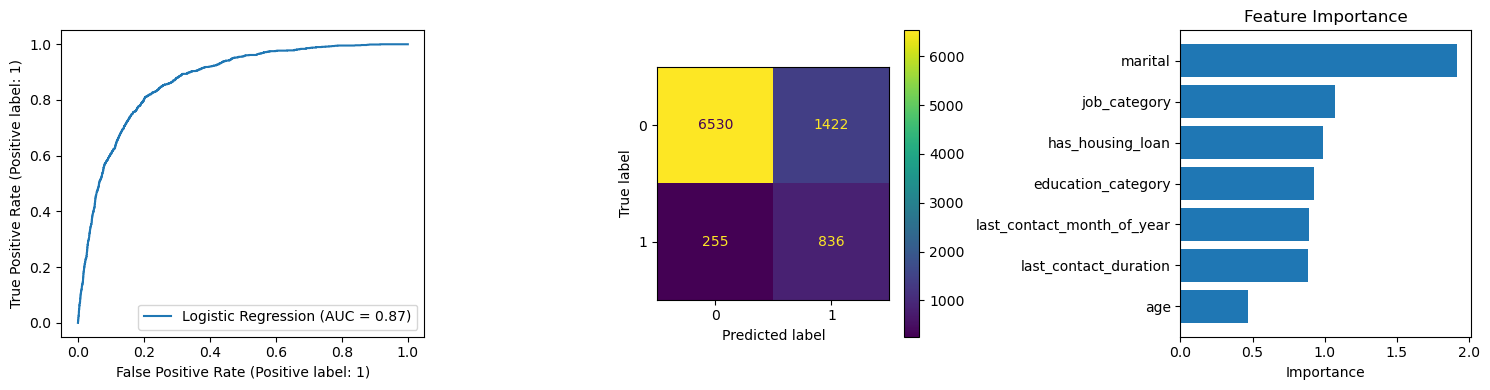

In [13]:
# Loop through classifiers, create pipelines and evaluate
for classifier_name, classifier in classifiers.items():
    feature_selection   = SelectFromModel(estimator=classifier)
    pipeline            = Pipeline(steps=[('preprocessor', preprocessor), ('feature_selection', feature_selection), ('classifier', classifier)])
    pipeline.fit(X_train_b, y_train_b)
    
    y_prob              = pipeline.predict_proba(X_val)[:, 1]
    fpr, tpr, _         = roc_curve(y_val, y_prob)
    roc_auc             = auc(fpr, tpr)
    y_pred              = pipeline.predict(X_val)
    precision           = precision_score(y_val, y_pred)
    recall              = recall_score(y_val, y_pred)
    accuracy            = accuracy_score(y_val, y_pred)
    f1                  = f1_score(y_val, y_pred)
    if hasattr(classifier, 'coef_'):
        feature_importance = dict(zip(X_train_b.columns, abs(classifier.coef_[0])))
    else:
        feature_importance = dict(zip(X_train_b.columns, classifier.feature_importances_))
    feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
    
    # Print metrics
    print("Classifier: ",           classifier_name)
    print("Precision: ",            precision)
    print("Recall: ",               recall)
    print("Accuracy: ",             accuracy)
    print("F1 Score: ",             f1)
    
    # Create plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [5, 4, 4]})
    # Create RocCurveDisplay
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=classifier_name, pos_label=1)
    roc_display.plot(ax=ax[0])

    # Create ConfusionMatrixDisplay
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    cm_display.plot(ax=ax[1])
    
    # Create Feature Importance Plot
    feature_names = list(feature_importance.keys())
    feature_values = list(feature_importance.values())
    ax[2].barh(feature_names, feature_values[::-1])
    ax[2].set_xlabel('Importance')
    ax[2].set_title('Feature Importance')
    
    # Show plot
    plt.tight_layout()
    plt.show()

# To do:
- Add precision recall curve for evaluation
- Include other features (maybe include forward or backward selection of features)
- Modify classifiers or try out others
- Try without undersampling